In [1]:
using JuMP
import Ipopt
using StaticArrays, LinearAlgebra
using Plots
using Symbolics: Symbolics, @variables, scalarize
using Latexify
using BlockArrays: Block, BlockVector, mortar, blocksizes
using Ipopt
using SparseArrays
using CSV
using DataFrames
using Tables

In [48]:
function uni_dyna(x,u)
    return [x[1]+dt*u[1]*cos(x[3]), x[2]+dt*u[1]*sin(x[3]), x[3]+dt*u[2]]
end

function circleShape(h, k, r); gr()
    theta = LinRange(0, 2*pi, 500)
    h.+ r*sin.(theta), k.+ r*cos.(theta)
end

N = 100
n_x = 6
n_u = 4
state_dimension = 3
control_dimension = 2
horizon = 25
tf = 10.
dt = tf/(N)
u1_b = 0.15
u2_b = 0.75

xo = @SVector [10.0,0.0]
ro = 4.0
ra = 1.0

Q = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 5, 5, 2, 2])*0.6 # This is reference tracking and control cost
Qf = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 5, 5, 2, 2])*50
R = Diagonal(@SVector [10, 10, 5, 5])*0.8

noise_level = 1.0

full_traj1 = []
full_traj2 = []

num_sim = 10

for sim in 1:num_sim

    x0 = [0,0,0,20,0.,pi] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]
    xf = [20,0.0,0,0,0.,pi] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]

    X_ref = hcat(collect(LinRange(x0[1],xf[1],N+1)), 
            collect(LinRange(x0[2],xf[2],N+1)),
            collect(LinRange(x0[3],xf[3],N+1)),
            collect(LinRange(x0[4],xf[4],N+1)), 
            collect(LinRange(x0[5],xf[5],N+1)),
            collect(LinRange(x0[6],xf[6],N+1)), zeros(N+1),zeros(N+1), zeros(N+1),zeros(N+1))

    problem_size = N*(n_x+n_u)

    X1_executed = zeros(N+1, 3)   # row 1 is start, row 2 after first step, … row N+1 after step N
    X2_executed = zeros(N+1, 3)
    U_executed  = zeros(N, 4)     # single control [u11,u12,u21,u22] at each step
    X1_executed[1, :] = x0[1:3]
    X2_executed[1, :] = x0[4:6]
    x1_curr = x0[1:3]
    x2_curr = x0[4:6]
    valid = 1

    for k in 1:N
        # Compute the “true” last index without going out-of-bounds:
        start_idx = k
        end_idx   = min(k + horizon, size(X_ref, 1))   # size(X_ref,1) is the total number of rows

        # Extract whatever rows are available:
        X_ref_mpc = X_ref[start_idx:end_idx, :]
        segment  = X_ref[start_idx:end_idx, :]    # this is (num_rows × 10)
        num_rows = size(segment, 1)

        if num_rows < horizon + 1
            # Force last_row to be a 1×10 matrix, not a 10-element Vector:
            last_row = segment[num_rows:num_rows, :]   # or segment[end:end, :]

            miss = (horizon + 1) - num_rows            # how many rows we need to pad
            pad  = repeat(last_row, miss, 1)           # now pad is (miss × 10)

            X_ref_mpc = vcat(segment, pad)             # both have 10 columns
        else
            X_ref_mpc = segment                        # already (horizon+1) × 10
        end



        model = Model(Ipopt.Optimizer)

        @variable(model, x11[1:horizon+1])
        @variable(model, x12[1:horizon+1])
        @variable(model, x13[1:horizon+1])
        @variable(model, x21[1:horizon+1])
        @variable(model, x22[1:horizon+1])
        @variable(model, x23[1:horizon+1])

        @variable(model, 0<=u11[1:horizon+1] , start = 0)
        @variable(model, u12[1:horizon+1], start = 0);
        @variable(model, 0<=u21[1:horizon+1], start = 0)
        @variable(model, u22[1:horizon+1], start = 0);

        @variable(model, -u1_b <= du11[1:horizon+1] <= u1_b, start = 0)
        @variable(model, -u2_b <= du12[1:horizon+1] <= u2_b, start = 0);
        @variable(model, -u1_b <= du21[1:horizon+1] <= u1_b, start = 0)
        @variable(model, -u2_b <= du22[1:horizon+1] <= u2_b, start = 0);

        fix(x11[1],x1_curr[1],force=true)
        fix(x12[1],x1_curr[2],force=true)
        fix(x13[1],x1_curr[3],force=true)
        fix(x21[1],x2_curr[1],force=true)
        fix(x22[1],x2_curr[2],force=true)
        fix(x23[1],x2_curr[3],force=true)

        X_full = vcat(x11',x12',x13',x21',x22',x23',u11',u21',u12',u22')
        U_full = vcat(du11',du21',du12',du22')

        @objective(model, Min, tr((X_full'[1:horizon,:] - X_ref_mpc[1:horizon,:])*Q*(X_full[:,1:horizon] - X_ref_mpc'[:,1:horizon])) + tr(U_full'*R*U_full))

        @constraint(model, [t in 1:horizon], uni_dyna([x11[t],x12[t],x13[t]],[u11[t],u12[t]]) == [x11[t+1],x12[t+1],x13[t+1]]);
        @constraint(model, [t in 1:horizon], uni_dyna([x21[t],x22[t],x23[t]],[u21[t],u22[t]]) == [x21[t+1],x22[t+1],x23[t+1]]);
        @constraint(model, [t in 1:horizon], [u21[t]+du21[t+1],u22[t]+du22[t+1]] == [u21[t+1],u22[t+1]]);
        @constraint(model, [t in 1:horizon], [u11[t]+du11[t+1],u12[t]+du12[t+1]] == [u11[t+1],u12[t+1]]);
        @constraint(model, [t in 1:horizon+1], (x21[t] - x11[t])^2 + (x22[t] - x12[t])^2 - ra^2 >= 0);
        @constraint(model, [t in 1:horizon+1], (xo[1] - x11[t])^2 + (xo[2] - x12[t])^2 - ro^2 >= 0);
        @constraint(model, [t in 1:horizon+1], (xo[1] - x21[t])^2 + (xo[2] - x22[t])^2 - ro^2 >= 0);

        for i in 1:horizon+1
            set_start_value(x11[i],X_ref_mpc[i,1]+ 0.1*(2*rand()-1))
            set_start_value(x12[i],X_ref_mpc[i,2]+ 0.1*(2*rand()-1))
            set_start_value(x13[i],X_ref_mpc[i,3]+ 0.1*(2*rand()-1))
            set_start_value(x21[i],X_ref_mpc[i,4]+ 0.1*(2*rand()-1))
            set_start_value(x22[i],X_ref_mpc[i,5]+ 0.1*(2*rand()-1))
            set_start_value(x23[i],X_ref_mpc[i,6]+ 0.1*(2*rand()-1))

            set_start_value(u11[i],X_ref_mpc[i,7])
            set_start_value(u12[i],X_ref_mpc[i,8])
            set_start_value(u21[i],X_ref_mpc[i,9])
            set_start_value(u22[i],X_ref_mpc[i,10])

            set_start_value(du11[i],0.0)
            set_start_value(du12[i],0.0)
            set_start_value(du21[i],0.0)
            set_start_value(du22[i],0.0)
            
        end

        optimize!(model)

        ts = termination_status(model)
        ps = primal_status(model)

        if ts != MOI.OPTIMAL && ts != MOI.LOCALLY_SOLVED
            valid = 0
            break 
        end

        u1_next = @SVector [ value(u11[1]), value(u12[1]) ]
        u2_next = @SVector [ value(u21[1]), value(u22[1]) ]
        nxt1 = uni_dyna(x1_curr, u1_next)
        nxt2 = uni_dyna(x2_curr, u2_next)
        X1_executed[k+1, :] = nxt1
        X2_executed[k+1, :] = nxt2
        U_executed[k, :]    = [u1_next[1], u1_next[2], u2_next[1], u2_next[2]]

        x1_curr = nxt1
        x2_curr = nxt2

        X1 = hcat(value.(x11),value.(x12),value.(x13))
        X2 = hcat(value.(x21),value.(x22),value.(x23))

        traj = hcat(value.(u11),value.(u12),value.(u21),value.(u22),
                    value.(x11),value.(x12),value.(x13), 
                    value.(x21),value.(x22),value.(x23))
    end

    if valid == 1
        if sim == 1
            # start a fresh figure for sim=1
            full_traj1 = X1_executed[1:100, :]
            full_traj2 = X2_executed[1:100, :]
            plot(
            X1_executed[:,1], X1_executed[:,2];
            color = :blue,
            label = "Agent 1"
            )
            plot!(
            X2_executed[:,1], X2_executed[:,2];
            color = :orange,
            label = "Agent 2"
            )
            # draw the obstacle once:
            c1, c2 = circleShape(xo[1], xo[2], ro)
            plot!(
            c1, c2;
            seriestype = :shape,
            fillalpha = 0.2,
            color = :gray,
            label = "Obstacle"
            )
            xlabel!("x"); ylabel!("y")
        else
            # overlay the new sim without redrawing the obstacle
            full_traj1 = vcat(full_traj1, X1_executed[1:100,:])
            full_traj2 = vcat(full_traj2, X2_executed[1:100,:])
            plot!(
            X1_executed[:,1], X1_executed[:,2];
            color = :blue,
            label = ""
            )
            plot!(
            X2_executed[:,1], X2_executed[:,2];
            color = :orange,
            label = ""
            )
        end
    end

end

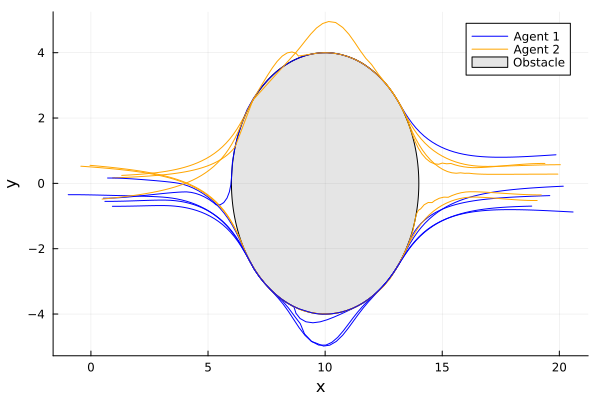

In [49]:
Plots.xlabel!("x")
Plots.ylabel!("y")

In [52]:
full_traj1

500×3 Matrix{Float64}:
  0.59776   -0.551187  0.0
  0.797237  -0.551187  0.00699895
  0.99674   -0.549791  0.0124243
  1.19625   -0.547312  0.0165929
  1.39577   -0.544001  0.0197621
  1.59528   -0.540058  0.0221399
  1.7948    -0.53564   0.0238947
  1.99433   -0.530871  0.0246599
  2.194     -0.525946  0.0238144
  2.39402   -0.521182  0.0212099
  ⋮                    
 17.3824    -0.744345  0.0536733
 17.5784    -0.733811  0.045601
 17.7709    -0.72503   0.0388081
 17.9574    -0.717789  0.0331532
 18.1351    -0.711896  0.0284941
 18.3011    -0.707162  0.0246877
 18.4544    -0.703378  0.021587
 18.5928    -0.700389  0.0190494
 18.7152    -0.698057  0.0169384

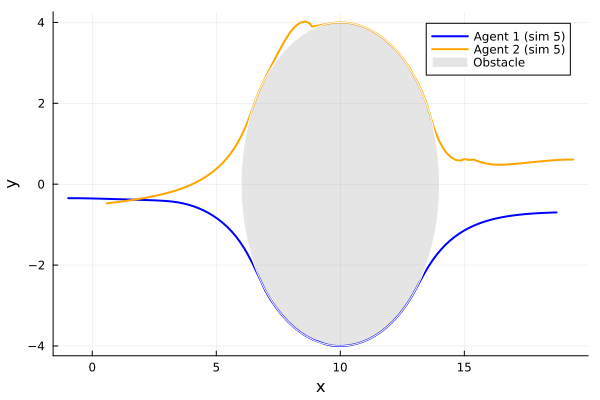

In [60]:
using Plots

# -------------------------------------------------------------------
# plot_selected_trajectories(full_traj1, full_traj2, sims_to_plot; obstacle)
#   full_traj1, full_traj2  :: matrices of size (100*n_sims)×3
#   sims_to_plot            :: a Vector{Int} listing which sim‐indices to draw
#   obstacle (optional)     :: tuple (c1,c2) or function to plot the circle
# -------------------------------------------------------------------
function plot_selected_trajectories(full_traj1::AbstractMatrix{<:Real},
                                    full_traj2::AbstractMatrix{<:Real},
                                    sims_to_plot::Vector{Int};
                                    obstacle = nothing)

    n_total_rows = size(full_traj1, 1)
    @assert size(full_traj1,2) == 3 "full_traj1 must be (100*n)×3"
    @assert size(full_traj2,2) == 3 "full_traj2 must be (100*n)×3"
    n_rows_per_sim = 100
    n_sims_total = Int(div(n_total_rows, n_rows_per_sim))
    @assert n_rows_per_sim * n_sims_total == n_total_rows "full_traj1 has to be a multiple of 100 rows"

    # Start a fresh plot
    plt = plot()
    for (i_sim_idx, sim_id) in enumerate(sims_to_plot)
        @assert 1 ≤ sim_id ≤ n_sims_total "sim_id out of range"

        # compute the row‐range for that particular simulation
        first_row = (sim_id - 1) * n_rows_per_sim + 1
        last_row  = sim_id * n_rows_per_sim

        # extract the 100×3 submatrix for Agent 1 and Agent 2
        traj1 = full_traj1[first_row:last_row, :]    # 100×3
        traj2 = full_traj2[first_row:last_row, :]

        # plot agent 1’s (x,y) in blue, and agent 2’s (x,y) in orange
        # label only the first trajectory in each category, to avoid legend clutter
        plot!(plt,
              traj1[:,1], traj1[:,2];
              color = :blue,
              linewidth = 2,
              label = i_sim_idx == 1 ? "Agent 1 (sim $sim_id)" : "")
        plot!(plt,
              traj2[:,1], traj2[:,2];
              color = :orange,
              linewidth = 2,
              label = i_sim_idx == 1 ? "Agent 2 (sim $sim_id)" : "")
    end

    # If requested, draw the obstacle circle once (outside the loop)
    if obstacle !== nothing
        c1, c2 = obstacle
        plot!(plt,
              c1, c2;
              seriestype   = :shape,
              fillalpha    = 0.2,
              color        = :gray,
              linecolor    = :white,
              label        = "Obstacle")
    end

    # finish styling
    xlabel!(plt, "x")
    ylabel!(plt, "y")
    return plt
end

# =============================================
# Example of how to call the above helper:
# =============================================

# Suppose after your main MPC‐loop you have something like:
#   full_traj1 = (100*n_sims)×3 matrix
#   full_traj2 = (100*n_sims)×3 matrix

# Let’s say you want to plot simulations 2, 5, and 7:
selected = [5]

# Precompute the obstacle points (if you want to draw it):
xo = @SVector [10.0, 0.0]   # center of circle
ro = 4.0                   # radius
c1, c2 = circleShape(xo[1], xo[2], ro)

# Now call the helper:
plt = plot_selected_trajectories(full_traj1, full_traj2, selected;
                                 obstacle = (c1, c2))

# If you are running in the REPL / notebook, this will display the figure.
display(plt)


In [61]:
CSV.write("data/mpc_traj1.csv",  Tables.table(full_traj1), writeheader=false)
CSV.write("data/mpc_traj2.csv",  Tables.table(full_traj2), writeheader=false)

"data/mpc_traj2.csv"

In [62]:
load_traj = Array(CSV.read("data/mpc_traj1.csv",DataFrame,header=false);)

500×3 Matrix{Float64}:
  0.59776   -0.551187  0.0
  0.797237  -0.551187  0.00699895
  0.99674   -0.549791  0.0124243
  1.19625   -0.547312  0.0165929
  1.39577   -0.544001  0.0197621
  1.59528   -0.540058  0.0221399
  1.7948    -0.53564   0.0238947
  1.99433   -0.530871  0.0246599
  2.194     -0.525946  0.0238144
  2.39402   -0.521182  0.0212099
  ⋮                    
 17.3824    -0.744345  0.0536733
 17.5784    -0.733811  0.045601
 17.7709    -0.72503   0.0388081
 17.9574    -0.717789  0.0331532
 18.1351    -0.711896  0.0284941
 18.3011    -0.707162  0.0246877
 18.4544    -0.703378  0.021587
 18.5928    -0.700389  0.0190494
 18.7152    -0.698057  0.0169384